In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

images = []
label = []
import os
for dirname, _, filenames in os.walk('E:/GOLEM/Dataset/Train/'):
    for filename in filenames:
        images.append(os.path.join(filename).split('/')[-1])
        label.append(os.path.join(dirname).split('/')[-1])

In [2]:
import torch
import torchvision
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms as T
from PIL import Image
import random
import time
from tqdm.notebook import tqdm
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
IMAGE = 'E:/GOLEM/Dataset/Train/'
TARGET_LABEL = {'jalan_lubang': 0, 
                'jalan_retak': 1, 
                'jalan_tidak_rusak': 2}

df = pd.DataFrame({'image':images, 'label': label})
df

,image,label
0,1.jpg,jalan_lubang
1,100.jpg,jalan_lubang
2,104.jpg,jalan_lubang
3,105.jpg,jalan_lubang
4,107.jpg,jalan_lubang
...,...,...
729,95.jpg,jalan_tidak_rusak
730,96.jpg,jalan_tidak_rusak
731,97.jpg,jalan_tidak_rusak
732,98.jpg,jalan_tidak_rusak


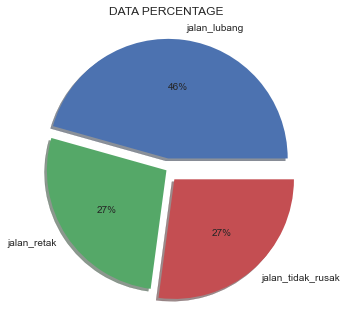

In [14]:
label, count = np.unique(df['label'].values, return_counts=True)
precentange = [x / np.sum(count) for x in count]
plt.style.use('seaborn')
plt.pie(precentange, labels = label, explode=[0.1, 0, 0.1],  autopct='%1.f%%', shadow=True)
plt.title('DATA PERCENTAGE')
plt.show()

In [15]:
class Jalanan(Dataset):
    def __init__(self, x, y, path, map_label=TARGET_LABEL, transform=None):
        self.X = x
        self.y = y
        self.path = path
        self.map_label = map_label
        self.transform = transform
        
    def __getitem__(self, idx):
        img = Image.open(self.path + str(self.y[idx]) + '/' + str(self.X[idx])).convert('RGB')
        label = self.map_label[self.y[idx]]
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, label

    def __len__(self):
        return len(self.X)
    
X_trainval, X_test, y_trainval, y_test = train_test_split(
    df['image'].values, df['label'].values, 
    test_size=0.15, stratify=df['label'].values, 
    random_state=77)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, 
    stratify=y_trainval, test_size=0.15,
    random_state=77)
len(X_train), len(X_val), len(X_test)

(529, 94, 111)

In [22]:
#DATALOADER
mean = [0.5548598 , 0.54704523, 0.54043627]
std = [0.1071739 , 0.10524916, 0.10435305]
batch_size = 24

train_transform = T.Compose([T.Resize((128, 128)),
                             T.RandomHorizontalFlip(),
                             T.RandomVerticalFlip(),
                             T.RandomRotation(20),
                             T.ToTensor(),
                             T.RandomErasing(scale=(0.02, 0.25)),
                             T.Normalize(mean, std)
                            ])

val_transform = T.Compose([T.Resize((128, 128)),
                           T.ToTensor(),
                           T.Normalize(mean, std),
                          ])

train_set = Jalanan(X_train, y_train, IMAGE, transform=train_transform)
val_set = Jalanan(X_val, y_val, IMAGE, transform=val_transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
                                           num_workers=0, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size*2, shuffle=False, 
                                         num_workers=0, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


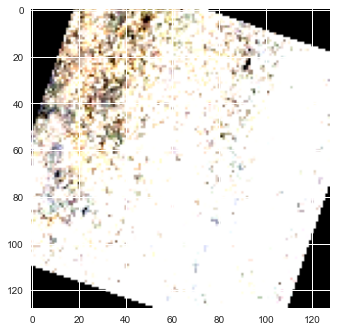

In [23]:
img, label = train_set[random.randint(0, len(X_train))]

plt.imshow(img.permute(1,2,0))

In [24]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=3, bias=True)
#model.classifier[6] = nn.Linear(4096, 20)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
def accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

epoch = 20
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epoch,
                                               steps_per_epoch=len(train_loader))

In [26]:
train_losses = []
val_losses =[]
train_accuracy = []
val_acc = []
for e in range(epoch):
    model.to(device)
    model.train()
    
    train_loss = 0
    train_acc = 0
    since = time.time()
    for image, label in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()
        
        image = image.to(device)
        label = label.to(device)
        output = model(image)
        loss = criterion(output, label)
        
        train_loss += loss
        train_acc += accuracy(output, label)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    else:
        with torch.no_grad():
            model.eval()
            
            running_loss = 0
            val_accuracy =0
            for image, label in val_loader:
                image = image.to(device)
                label = label.to(device)

                output = model(image)
                loss = criterion(output, label)
                val_accuracy += accuracy(output, label)
                running_loss += loss
                
    train_losses.append((train_loss/len(train_loader)).item())
    val_losses.append((running_loss/len(val_loader)).item())
    train_accuracy.append(train_acc/ len(train_loader))
    val_acc.append(val_accuracy/len(val_loader))
    
    print('epochs {}/{}..'.format(e+1, epoch),
          'train loss {:.3f}..'.format(train_loss/len(train_loader)),
          'val loss {:.3f}..'.format(running_loss/len(val_loader)),
          'train accuracy {:.3f}..'.format(train_acc/ len(train_loader)),
          'val accuracy {:.3f}..'.format(val_accuracy/len(val_loader)),
          'time {:.3f} s'.format(time.time() - since)
         )

  0%|          | 0/23 [00:00<?, ?it/s]

epochs 1/20.. train loss 0.562.. val loss 0.318.. train accuracy 0.766.. val accuracy 0.904.. time 24.570 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 2/20.. train loss 0.275.. val loss 0.113.. train accuracy 0.888.. val accuracy 0.989.. time 24.826 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 3/20.. train loss 0.196.. val loss 0.348.. train accuracy 0.929.. val accuracy 0.883.. time 26.057 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 4/20.. train loss 0.226.. val loss 0.503.. train accuracy 0.924.. val accuracy 0.914.. time 26.439 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 5/20.. train loss 0.371.. val loss 5.375.. train accuracy 0.888.. val accuracy 0.786.. time 26.020 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 6/20.. train loss 0.241.. val loss 0.442.. train accuracy 0.917.. val accuracy 0.936.. time 25.781 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 7/20.. train loss 0.248.. val loss 0.031.. train accuracy 0.918.. val accuracy 0.979.. time 26.008 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 8/20.. train loss 0.100.. val loss 0.008.. train accuracy 0.973.. val accuracy 1.000.. time 26.405 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 9/20.. train loss 0.241.. val loss 0.037.. train accuracy 0.931.. val accuracy 0.989.. time 28.179 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 10/20.. train loss 0.204.. val loss 0.098.. train accuracy 0.933.. val accuracy 0.947.. time 26.896 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 11/20.. train loss 0.190.. val loss 0.443.. train accuracy 0.942.. val accuracy 0.862.. time 27.309 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 12/20.. train loss 0.259.. val loss 0.112.. train accuracy 0.928.. val accuracy 0.957.. time 27.175 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 13/20.. train loss 0.116.. val loss 0.063.. train accuracy 0.966.. val accuracy 0.979.. time 26.622 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 14/20.. train loss 0.161.. val loss 0.012.. train accuracy 0.937.. val accuracy 1.000.. time 26.874 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 15/20.. train loss 0.052.. val loss 0.006.. train accuracy 0.993.. val accuracy 1.000.. time 27.628 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 16/20.. train loss 0.033.. val loss 0.003.. train accuracy 0.996.. val accuracy 1.000.. time 27.922 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 17/20.. train loss 0.081.. val loss 0.002.. train accuracy 0.955.. val accuracy 1.000.. time 26.664 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 18/20.. train loss 0.027.. val loss 0.003.. train accuracy 1.000.. val accuracy 1.000.. time 26.982 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 19/20.. train loss 0.137.. val loss 0.002.. train accuracy 0.947.. val accuracy 1.000.. time 26.271 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 20/20.. train loss 0.028.. val loss 0.002.. train accuracy 0.996.. val accuracy 1.000.. time 25.735 s


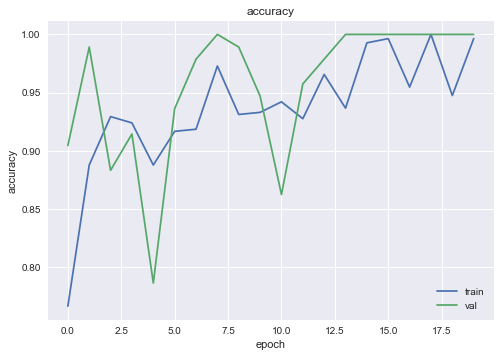

In [27]:
plt.plot(train_accuracy, label='train')
plt.title('accuracy')
plt.ylabel('accuracy'); plt.xlabel('epoch')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

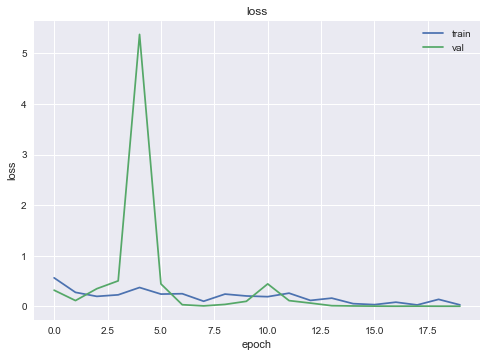

In [28]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.title('loss')
plt.ylabel('loss'); plt.xlabel('epoch')
plt.legend()
plt.show()

In [29]:
test_set = Jalanan(X_test, y_test, IMAGE, transform=val_transform)

def predict(model, img, label):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        output = model(img)
        pred = torch.argmax(F.softmax(output, dim=1)).cpu().item()
    return pred

test_predict = []
true_label = []
for i in range(len(test_set)):
    img, label = test_set[i]
    prediction = predict(model, img, label)
    test_predict.append(prediction)
    true_label.append(label)

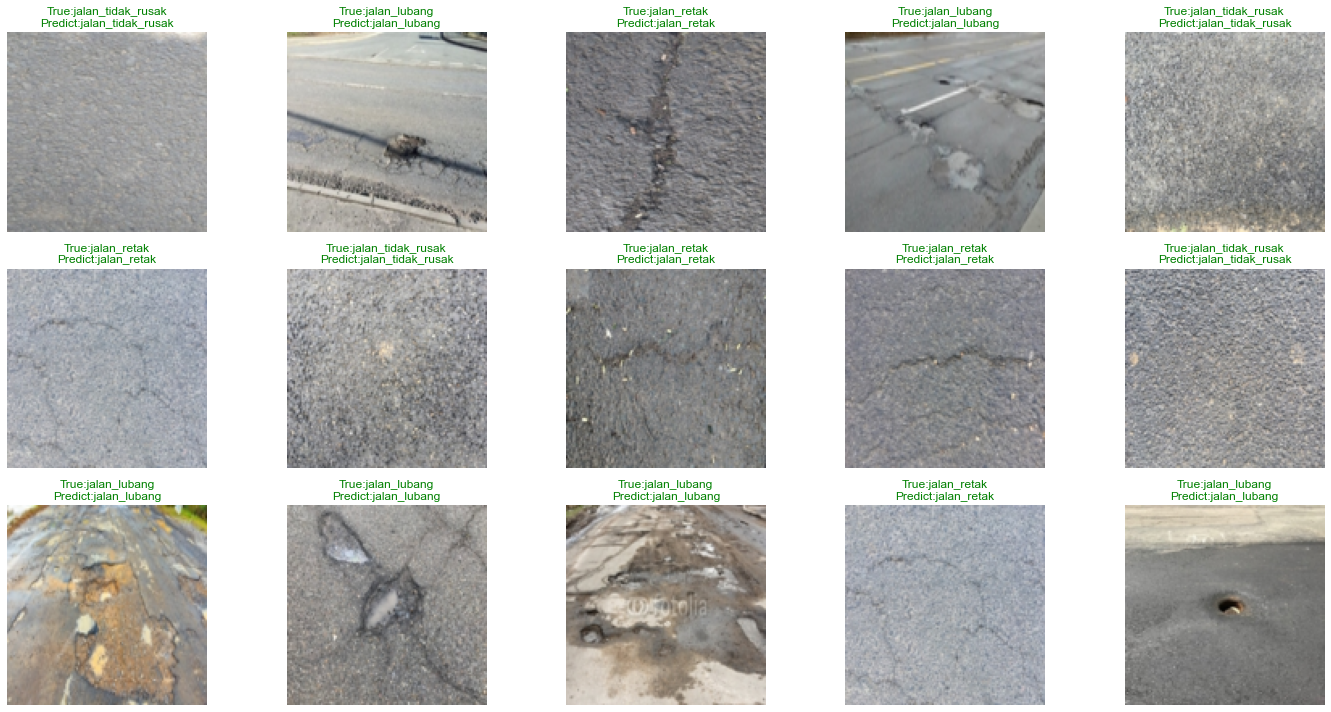

In [33]:
ints_2_label = {0: 'jalan_lubang', 
                1: 'jalan_retak', 
                2: 'jalan_tidak_rusak'}

random_selection = np.random.randint(0, len(test_predict), 15)

fig = plt.figure(figsize=(20, 10))

test_set = Jalanan(X_test, y_test, IMAGE, transform=T.Resize((124,124)))
for i, idx in enumerate(random_selection):
    image, label = test_set[idx]
    ax = fig.add_subplot(3, 5, i+1, xticks=[], yticks = [])
    ax.imshow(image)
    ax.set_title('True:{}\nPredict:{}'.format(ints_2_label[label], ints_2_label[test_predict[idx]]),
                color=("green" if label == test_predict[idx] else 'red'), fontsize=12)

plt.tight_layout() #want faster comment or delete this
plt.show()